## Data loading

In [12]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.metrics import create_kl_adjacency
from utils.internal_validation_metrics import manual_silhouette_score, manual_dbi, manual_modularity
from utils.graph_visualization import graph_viz, plot_spectral_clusters

In [13]:
import pandas as pd
import pyarrow.parquet as pq
from IPython.display import display
# Read Parquet with PyArrow, keeping pandas metadata
table = pq.read_table("../data/sequence_dataset.parquet", use_pandas_metadata=True)
df = table.to_pandas()
display(df.head(5))

# Robust CTM stacking that unwraps singleton nesting and coerces to float array
def stack_ctm(entry):
    import ast

    e = entry
    # unwrap extra singleton nesting like [[...]] -> [...]
    while isinstance(e, (list, tuple)) and len(e) == 1:
        e = e[0]

    # if stored as a string, try to parse it
    if isinstance(e, str):
        e = ast.literal_eval(e)

    arr = np.array(e, dtype=object)

    # if object dtype, try to build numeric rows
    if arr.dtype == object:
        try:
            rows = [np.asarray(r, dtype=float) for r in arr]
            arr = np.vstack(rows)
        except Exception as exc:
            raise ValueError(f"Cannot convert CTM entry to numeric array: {exc}")

    # handle an extra leading singleton dimension (1,129,129)
    if arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1:] == (129, 129):
        arr = arr.squeeze(0)

    if arr.shape != (129, 129):
        raise ValueError(f"Unexpected CTM shape {arr.shape}; expected (129,129)")

    return arr.astype(float)

def normalize_global(M: np.ndarray) -> np.ndarray:
    total = M.sum()
    return M / total if total != 0 else M.astype(float)

# Apply conversion + normalization with index-aware errors for easier debugging
ctm_matrices = []
for i, e in enumerate(df["ctm"]):
    try:
        mat = stack_ctm(e)
        mat = normalize_global(mat)
        ctm_matrices.append(mat)
    except Exception as exc:
        raise ValueError(f"Error processing ctm at row {i}: {exc}")

df["ctm_matrix"] = ctm_matrices

# Quick verification
print("Rows:", len(df))
print("Example shape (row 0):", df.loc[0, "ctm_matrix"].shape)
print("Sum of example (row 0):", df.loc[0, "ctm_matrix"].sum())
# Optionally check that every matrix sums to 1 (or 0 if originally all zeros)
sums = df["ctm_matrix"].apply(np.sum)
print("Number of matrices with sum == 1:", (np.isclose(sums, 1.0)).sum())
print("Number of zero-sum matrices:", (sums == 0).sum())

,name,note_sequence,ctm,id,rating,themes,keywords,involved_companies,first_release_year
0,Star Wars: Rogue Squadron II - Rogue Leader,"[55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001
1,Star Wars: Rogue Squadron II - Rogue Leader,"[59, 38, 47, 47, 59, 47, 47, 38, 59, 47, 38, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001
2,Donkey Kong Jungle Beat,"[45, 64, 61, 57, 64, 61, 57, 45, 57, 64, 61, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1097,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004
3,Donkey Kong Jungle Beat,"[70, 71, 72, 73, 42, 23, 49, 73, 61, 56, 49, 6...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1097,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004
4,Viewtiful Joe,"[33, 33, 75, 81, 33, 36, 36, 36, 38, 38, 59, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",341259,0,"[""Action""]",[],"[""Clover Studio"", ""Capcom""]",2004


Rows: 3320
Example shape (row 0): (129, 129)
Sum of example (row 0): 1.0
Number of matrices with sum == 1: 3320
Number of zero-sum matrices: 0


In [14]:
p = Path("../data") / "ctms_distance_matrix.npy"

if p.exists():
    print("Distance matrix already exists; loading from file.")
    distance_matrix = np.load(p)
else:
    ctms_list = df['ctm_matrix'].tolist()
    distance_matrix = create_kl_adjacency(ctms_list)
    np.save(p, distance_matrix)

Distance matrix already exists; loading from file.


## Spectral clustering

### Distances to similarity

In [15]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def distance_to_local_scaled_similarity(D: np.ndarray, k: int = 15, scale_factor: float = 2.0) -> np.ndarray:
    """
    Robust Self-Tuning Spectral Clustering.
    
    Fixes 'clustered towards 0' by:
    1. Using MEAN distance for sigma (prevents tiny sigma from duplicates).
    2. Adding a scale_factor to widen the Gaussian kernel.
    """
    n = D.shape[0]
    
    # 1. k-NN search
    # Request k+1 because the first neighbor is self (dist=0)
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='precomputed')
    nbrs.fit(D)
    knn_dists, knn_indices = nbrs.kneighbors(D)
    
    # 2. Calculate ROBUST Sigmas
    # Instead of just the k-th neighbor, use the MEAN of the k neighbors.
    # This prevents 'collapsing' if the first few neighbors are duplicates.
    # scale_factor (e.g. 2.0) ensures the tail of the distribution doesn't vanish too fast.
    sigmas = np.mean(knn_dists[:, 1:], axis=1) * scale_factor
    
    # Safety: prevent division by zero if all neighbors are identical
    avg_global_dist = np.mean(knn_dists[:, 1:]) + 1e-9
    sigmas[sigmas < 1e-9] = avg_global_dist
    
    sim_matrix = np.zeros((n, n))
    
    # 3. Compute Weights
    for i in range(n):
        neighbors = knn_indices[i, 1:]
        
        # Original squared distances
        d_sq = knn_dists[i, 1:] ** 2
        
        # Scaling denominator: sigma_i * sigma_j
        # This is the Zelnik-Manor magic: it adapts to the density of BOTH points.
        sigma_prod = sigmas[i] * sigmas[neighbors]
        
        # Compute Gaussian
        weights = np.exp(-d_sq / sigma_prod)
        
        # Hard check: If weights are still microscopic, clip them to a minimum
        # This ensures the graph doesn't mathematically sever.
        weights[weights < 1e-4] = 1e-4 
        
        sim_matrix[i, neighbors] = weights

    # 4. Symmetrize (Maximum preserves the strongest connection)
    sim_matrix = np.maximum(sim_matrix, sim_matrix.T)
    np.fill_diagonal(sim_matrix, 0)
    
    return sim_matrix

sim_matrix = distance_to_local_scaled_similarity(distance_matrix, k=15, scale_factor=2.0)

### Spectral Embedding + k-Means

In [16]:
import pickle
from pathlib import Path
from scipy.linalg import fractional_matrix_power
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# File to save/load clustering results
p_clusters = Path("../data/ctms_clusters.pkl")
k_values = range(2, 15)

if p_clusters.exists():
    print("Clustering results already exist; loading from file.")
    with open(p_clusters, "rb") as f:
        results = pickle.load(f)
    labels_all = results['labels_all']
    scores = results['silhouette_scores']
    dbi_scores = results['dbi_scores']
    mod_scores = results['modularity_scores']
    X_norm_all = results.get('X_norm_all', None)  # load if saved
else:
    from scipy.linalg import eigh

    # Compute Laplacian
    D = np.diag(sim_matrix.sum(axis=1))
    D_inv_sqrt = fractional_matrix_power(D, -0.5)
    L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

    scores = []
    dbi_scores = []
    mod_scores = []
    labels_all = {}     # store labels for each k
    X_norm_all = {}     # store normalized eigenvectors for each k

    for k in k_values:
        eigvals, eigvecs = eigh(L_sym)
        X = eigvecs[:, :k]
        X_norm = normalize(X, norm='l2', axis=1)
        X_norm_all[k] = X_norm  # save normalized vectors

        labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_norm)
        labels_all[k] = labels

        # silhouette
        sill = manual_silhouette_score(X_norm, labels)
        scores.append(sill)

        # Davies–Bouldin Index (lower is better)
        dbi = manual_dbi(X_norm, labels)
        dbi_scores.append(dbi)

        # modularity
        mod = manual_modularity(sim_matrix, labels)
        mod_scores.append(mod)

    # save results including X_norm_all
    with open(p_clusters, "wb") as f:
        pickle.dump({
            'labels_all': labels_all,
            'silhouette_scores': scores,
            'dbi_scores': dbi_scores,
            'modularity_scores': mod_scores,
            'X_norm_all': X_norm_all
        }, f)

Clustering results already exist; loading from file.


In [17]:
avg_dispersion = []

for k in k_values:
    X_norm = X_norm_all[k]
    labels = labels_all[k]
    dispersion = 0

    for cluster_id in range(k):
        cluster_points = X_norm[labels == cluster_id]  # boolean mask is valid now
        if len(cluster_points) > 1:
            centroid = cluster_points.mean(axis=0)
            dispersion += np.mean(np.linalg.norm(cluster_points - centroid, axis=1))

    dispersion /= k
    avg_dispersion.append(dispersion)

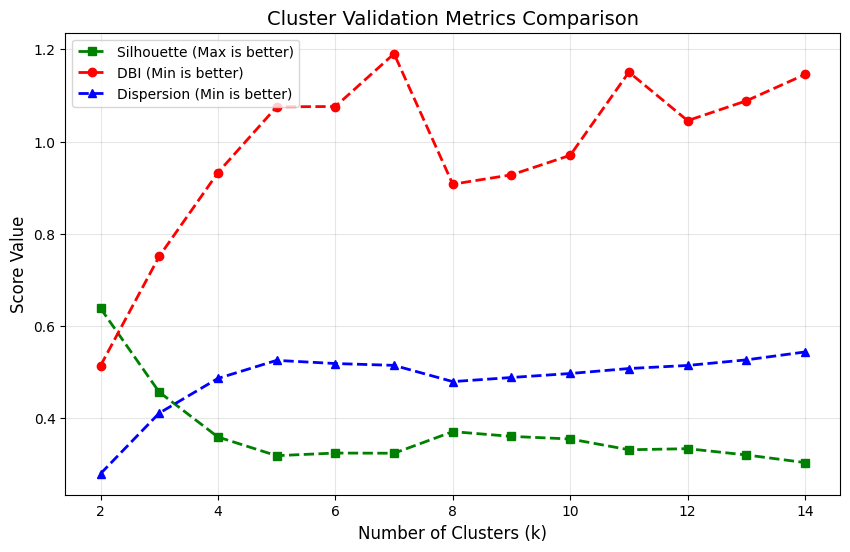

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
plt.figure(figsize=(10, 6))

# 1. Silhouette (Higher is Better) - Solid Green
plt.plot(k_values, scores, 'g--s', linewidth=2, label='Silhouette (Max is better)')

# 2. DBI (Lower is Better) - Dashed Red
plt.plot(k_values, dbi_scores, 'r--o', linewidth=2, label='DBI (Min is better)')

# 3. Dispersion (Elbow) - Dashed Blue
plt.plot(k_values, avg_dispersion, 'b--^', linewidth=2, label='Dispersion (Min is better)')

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Score Value', fontsize=12)
plt.title('Cluster Validation Metrics Comparison', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', frameon=True)

plt.show()

### Pick best $k$

In [19]:
best_k = 8
best_labels = labels_all[best_k]
print("Best k:", best_k)
print(f"Silhouette score for k={best_k}: {manual_silhouette_score(X_norm_all[best_k], best_labels):.4f}")

Best k: 8
Silhouette score for k=8: 0.3710


In [20]:
# Ensure matrices_df exists (build from df if missing)
if 'matrices_df' not in globals():
    if 'ctm_matrix' in df.columns:
        matrices_df = df[['ctm_matrix']].rename(columns={'ctm_matrix': 'ctm'}).copy()
    elif 'ctm' in df.columns:
        matrices_df = df[['ctm']].copy()
    else:
        raise ValueError("Cannot build matrices_df: neither 'ctm_matrix' nor 'ctm' found in df.")
    matrices_df.index.name = 'song_idx'

# Choose labels: prefer best_labels, fall back to other globals if necessary
if 'best_labels' in globals():
    labels = best_labels
elif 'labels' in globals():
    labels = labels
elif 'labels_all' in globals() and 'best_k' in globals():
    labels = labels_all[best_k]
else:
    raise ValueError("No clustering labels found in globals (expected 'best_labels' or 'labels').")

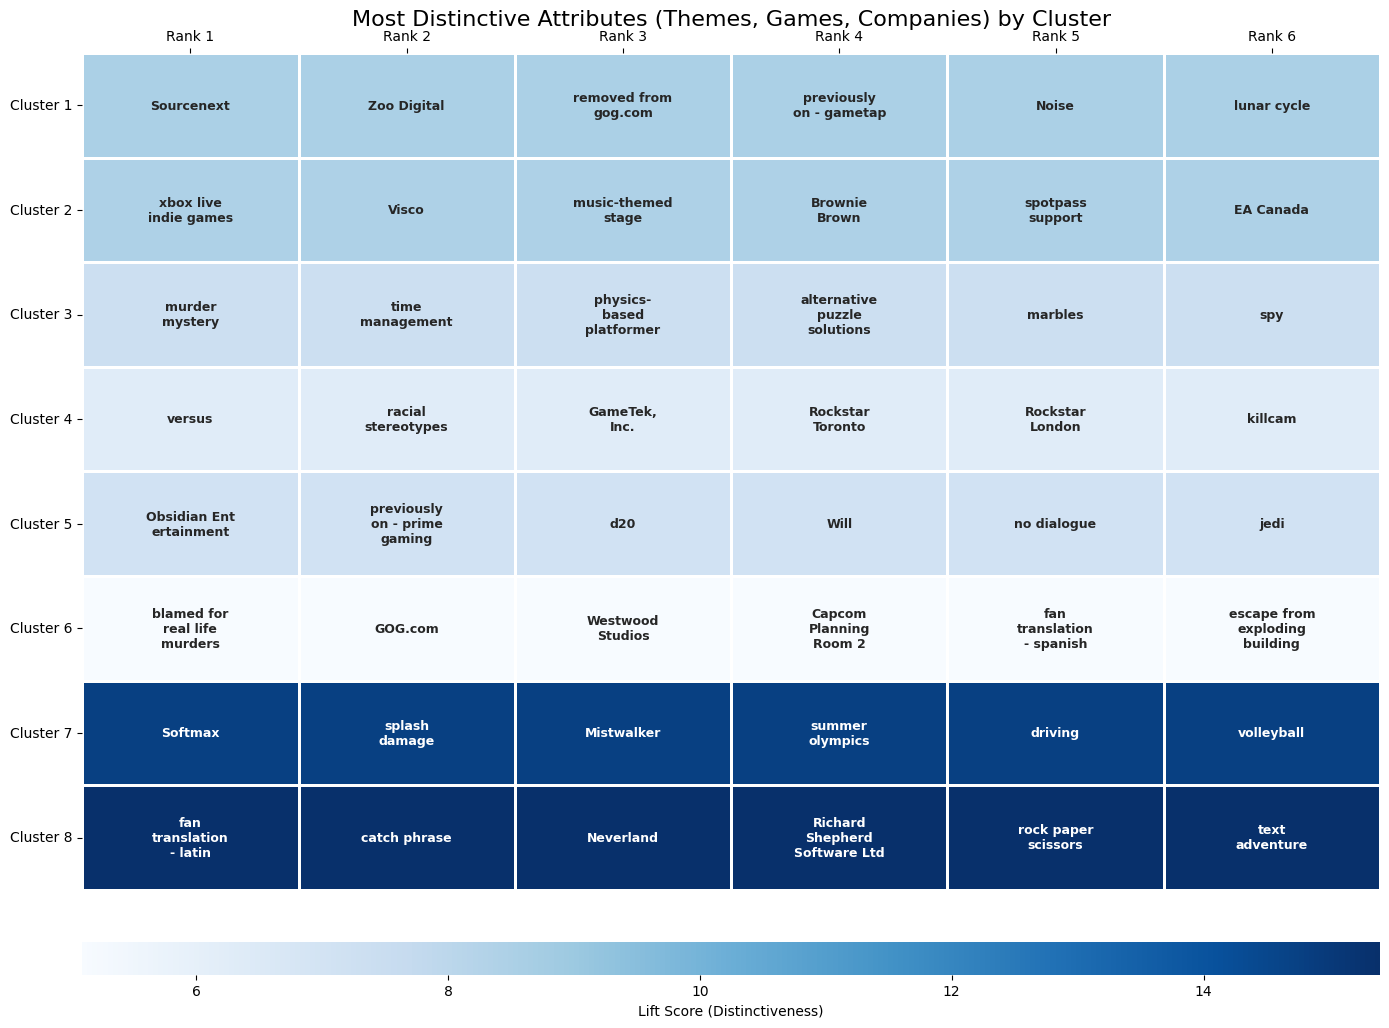

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import ast

def plot_merged_attribute_heatmap(df, labels, top_n=5):
    """
    Merges 'themes', 'keywords', 'involved_companies', and 'game' into a single 
    analysis pool and plots distinctive terms per cluster.
    """
    local_df = df.copy()
    local_df['cluster'] = labels
    
    # Define the columns we want to merge
    # Ensure these exist in your dataframe; remove any that don't
    target_cols = ["themes", "keywords", "involved_companies", "game"]
    valid_cols = [c for c in target_cols if c in local_df.columns]
    
    # --- STEP 1: NORMALIZE EVERYTHING TO LISTS ---
    for col in valid_cols:
        # Fill NaNs with empty list representation
        local_df[col] = local_df[col].fillna("[]")
        
        def standardize_to_list(val):
            try:
                # Case A: It's already a list -> Keep it
                if isinstance(val, list):
                    return val
                
                # Case B: It's a string
                if isinstance(val, str):
                    val = val.strip()
                    # Case B1: Stringified list "['Action', 'FPS']" -> Convert to list
                    if val.startswith('[') and val.endswith(']'):
                        return ast.literal_eval(val)
                    # Case B2: Regular string "Halo 3" -> Wrap in list ['Halo 3']
                    # Check if empty string
                    if val == "" or val == "[]":
                        return []
                    return [val]
                
                # Case C: Other (numbers, etc) -> Wrap in list
                return [str(val)]
            except:
                return []

        local_df[col] = local_df[col].apply(standardize_to_list)

    # --- STEP 2: MERGE COLUMNS ---
    # Now that all columns are actual lists, we can sum them row-wise
    # This concatenates ['Halo'] + ['Action'] -> ['Halo', 'Action']
    local_df['all_tags'] = local_df[valid_cols].sum(axis=1)

    # --- STEP 3: EXPLODE ---
    exploded_df = local_df.explode('all_tags')
    
    # Clean up: remove short garbage strings or numbers that might have slipped in
    exploded_df['all_tags'] = exploded_df['all_tags'].astype(str)
    exploded_df = exploded_df[exploded_df['all_tags'].str.len() > 2]

    # --- STEP 4: CALCULATE METRICS (LIFT) ---
    global_counts = exploded_df['all_tags'].value_counts(normalize=True)
    unique_clusters = sorted(local_df['cluster'].unique())
    
    lift_grid = np.zeros((len(unique_clusters), top_n))
    word_grid = np.full((len(unique_clusters), top_n), "", dtype=object)
    
    for i, c in enumerate(unique_clusters):
        c_counts = exploded_df[exploded_df['cluster'] == c]['all_tags'].value_counts(normalize=True)
        
        # Calculate Lift
        lift = c_counts / global_counts.reindex(c_counts.index).fillna(1)
        
        top_k = lift.sort_values(ascending=False).head(top_n)
        
        for rank, (word, score) in enumerate(top_k.items()):
            if rank < top_n:
                lift_grid[i, rank] = score
                # Wrap text for heatmap
                clean_word = textwrap.fill(str(word), width=12) 
                word_grid[i, rank] = clean_word

    # --- STEP 5: PLOT ---
    plt.figure(figsize=(14, len(unique_clusters) * 1.4))
    
    ax = sns.heatmap(
        lift_grid, 
        annot=word_grid, 
        fmt="", 
        cmap="Blues", 
        linewidths=1.0,
        linecolor='white',
        yticklabels=[f"Cluster {c+1}" for c in unique_clusters],
        xticklabels=[f"Rank {i+1}" for i in range(top_n)],
        annot_kws={"size": 9, "weight": "bold"},
        cbar_kws={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Lift Score (Distinctiveness)"}
    )
    
    ax.set_title("Most Distinctive Attributes (Themes, Games, Companies) by Cluster", fontsize=16, pad=20)
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    
    plt.tight_layout()
    plt.show()

# Run it
plot_merged_attribute_heatmap(df, labels_all[best_k], top_n=6)